# Import Iibrary

In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from dataset.dataset_generator import DatasetGenerator
from dataset.MICE import FillNaN
from dataset.apply_PCA import MakePCA

from model.tree_model import LGBM, XGB, CatBoost


# Load Data

In [2]:
data_path = '../data'
dataset_gen = DatasetGenerator(data_path)

df = dataset_gen.generate_dataset()

df, category_cols, conti_cols = dataset_gen.feature_engineering(df)


100%|██████████| 107/107 [00:03<00:00, 29.32it/s]


In [3]:
# 파생 변수 생성에만 필요했던 변수들
drop_cols1 = ['long_liquidations_bybit', 'short_liquidations_bybit', 'long_liquidations_bitfinex', 'short_liquidations_bitfinex', 'long_liquidations_binance', 'short_liquidations_binance',
             'buy_volume_deribit', 'sell_volume_deribit','buy_volume_bybit', 'sell_volume_bybit','buy_volume_okx', 'sell_volume_okx']

# corr 0.9 이상
drop_cols2 = [
    'coinbase_premium_gap', 'long_liquidations_usd', 'short_liquidations_usd', 'buy_sell_ratio', 'sell_ratio', 'sell_volume','block_mean', 'block_mean_usd', 'blockreward',
    'fees_total', 'fees_transaction_mean', 'fees_transaction_median', 'supply_total', 'utxo_count', 'supply_new', 'velocity_supply_total', 'fees_reward_percent', 'hashrate', 'sender_count' ]


# 파생 변수 중에 corr 0.9 이상
drop_cols3 = ['long_liquidation_interest_ratio', 'short_liquidation_interest_ratio', 'volume_interest_ratio', 'buy_sell_volume_ratio', 'volume_index']

drop_cols = drop_cols1 + drop_cols2 + drop_cols3

df_select = df.drop(columns = drop_cols)


In [4]:
df_select.head(2)


,ID,target,_type,coinbase_premium_index,funding_rates,funding_rates_bitmex,long_liquidations,short_liquidations,open_interest,buy_ratio,...,fees_activity_ratio,tokens_fee_ratio,block_interval_difficulty_reward_ratio,taker_interest_ratio,premium_liquidation_ratio,velocity_supply_ratio,funding_taker_ratio,M,Is_Afternoon_Evening,Is_Weekend
0,2023-01-01 00:00:00,2.0,train,-0.059650,0.005049,0.0014,0.012,0.000,6.271344e+09,0.475003,...,7.202686e-10,58919.999796,8.421701e+14,0.015604,1.904329e-22,3.590163e-09,179.185118,1,0,1
1,2023-01-01 01:00:00,1.0,train,-0.053047,0.005049,0.0014,0.000,0.712,6.288683e+09,0.623454,...,1.436218e-09,50472.421939,1.125007e+14,0.010140,8.697117e-23,2.350919e-09,327.913566,1,0,1


# Fill Na

In [5]:
fill_nan = FillNaN(df_select)
filled_df = fill_nan.MICE()


[IterativeImputer] Completing matrix with shape (8760, 55)
[IterativeImputer] Ending imputation round 1/15, elapsed time 20.78
[IterativeImputer] Change: 1.7917901943118574e+19, scaled tolerance: 8.355941137274474e+19 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (2792, 55)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.04


# Log transform

In [6]:
log_df = filled_df.copy()

In [7]:
columns_to_log_transform = [
    'funding_rates_bitmex', 'long_liquidations', 'short_liquidations',
    'buy_volume', 'buy_sell_ratio_huobi', 'fees_total_usd',
    'fees_transaction_mean_usd', 'fees_transaction_median_usd', 'blockreward_usd',
    'block_interval', 'tokens_transferred_total', 'tokens_transferred_mean',
    'block_bytes', 'network_active', 'profitability', 'leverage', 'market_health', 
    'tokens_fee_ratio'
]

# 로그 변환: log1p를 사용하여 (log(1 + x)) 적용
log_df[columns_to_log_transform] = log_df[columns_to_log_transform].apply(np.log1p)

# MinMax Scaling

In [8]:
MMdf = log_df.copy()

In [9]:
train_df = MMdf[MMdf._type == 'train'].drop(columns=['_type', 'target', 'ID','M'])
test_df = MMdf[MMdf._type == 'test'].drop(columns=['_type', 'target', 'ID','M'])

numeric_cols_train = train_df.select_dtypes(include=['float64', 'int64']).columns

scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_df[numeric_cols_train])
train_df[numeric_cols_train] = train_scaled

test_scaled = scaler.transform(test_df[numeric_cols_train])
test_df[numeric_cols_train] = test_scaled

minmaxdf = pd.concat([MMdf[['_type', 'target', 'ID','M']], pd.concat([train_df, test_df], axis=0)], axis=1)
minmaxdf.head(2)


,_type,target,ID,M,coinbase_premium_index,funding_rates,funding_rates_bitmex,long_liquidations,short_liquidations,open_interest,...,hashrate_difficulty_reward_ratio,fees_activity_ratio,tokens_fee_ratio,block_interval_difficulty_reward_ratio,taker_interest_ratio,premium_liquidation_ratio,velocity_supply_ratio,funding_taker_ratio,Is_Afternoon_Evening,Is_Weekend
0,train,2.0,2023-01-01 00:00:00,1.0,0.492212,0.623464,0.702435,0.001562,0.000000,0.385656,...,0.270434,0.001113,0.821765,0.125697,0.009775,1.822592e-22,0.196608,0.770048,0.0,1.0
1,train,1.0,2023-01-01 01:00:00,1.0,0.494355,0.623463,0.702435,0.000000,0.065954,0.387585,...,0.065730,0.002449,0.803145,0.016748,0.005718,7.879755e-23,0.125858,0.770186,0.0,1.0


# DF1

In [10]:
intervals=[6,12,24,48,72]
ma_col_lst = set(conti_cols)-set(drop_cols)
df_select_ma = dataset_gen.moving_average(minmaxdf, ma_col_lst, intervals)

In [11]:
# ccf 에서 상관성이 높았던 변수들 (EDA 참고)
shift_col_lst = ['funding_rates',  'funding_rates_bitmex', 'open_interest', 'transactions_count_total', 'transactions_count_mean', 'block_mean', 'block_mean_usd',
           'fees_total', 'fees_total_usd', 'fees_reward_percent', 'difficulty', 'utxo_count', 'supply_total', 'hashrate', 'fees_transaction_mean',
           'fees_transaction_mean_usd', 'fees_transaction_median', 'fees_transaction_median_usd', 'blockreward_usd', 'tokens_transferred_mean',
           'tokens_transferred_median', 'velocity_supply_total', 'address_diff', 'profitability', 'fee_index'
]

# shift 변수 추가
shift_col_lst = set(shift_col_lst) - set(drop_cols)
df_select_ma_shift = dataset_gen.shift_feature(df_select_ma, shift_col_lst, intervals=[_ for _ in range(1, 24)])

In [12]:
df_select_ma_shift.head(3)

,_type,target,ID,M,coinbase_premium_index,funding_rates,funding_rates_bitmex,long_liquidations,short_liquidations,open_interest,...,transactions_count_mean_14,transactions_count_mean_15,transactions_count_mean_16,transactions_count_mean_17,transactions_count_mean_18,transactions_count_mean_19,transactions_count_mean_20,transactions_count_mean_21,transactions_count_mean_22,transactions_count_mean_23
0,train,2.0,2023-01-01 00:00:00,1.0,0.492212,0.623464,0.702435,0.001562,0.000000,0.385656,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,train,1.0,2023-01-01 01:00:00,1.0,0.494355,0.623463,0.702435,0.000000,0.065954,0.387585,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,train,1.0,2023-01-01 02:00:00,1.0,0.492763,0.623459,0.702435,0.000000,0.000000,0.387375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
_target = df["target"]
final_df = df_select_ma_shift.ffill().fillna(-999).assign(target = _target)

train_df = final_df[final_df._type == 'train'].drop(columns = '_type')
test_df = final_df[final_df._type == 'test'].drop(columns = '_type')

In [14]:
# train_test_split 으로 valid set, train set 분리
x_train_random, x_valid_random, y_train_random, y_valid_random = train_test_split(
    train_df.drop(columns = ['ID', 'target']), 
    train_df["target"].astype(int), 
    test_size=0.2,
    random_state=42,
    stratify=train_df["target"].astype(int) 
)

In [15]:
# time series valid, train set 분리
x_train_ts = train_df[train_df.ID < '2023-11-01'].drop(["target", "ID"], axis = 1)
y_train_ts = train_df[train_df.ID < '2023-11-01']["target"].astype(int)

x_valid_ts = train_df[train_df.ID >= '2023-11-01'].drop(["target", "ID"], axis = 1)
y_valid_ts = train_df[train_df.ID >= '2023-11-01']["target"].astype(int)

In [16]:
x_train_random.replace([np.inf, -np.inf], np.nan, inplace=True)
x_valid_random.replace([np.inf, -np.inf], np.nan, inplace=True)

x_train_ts.replace([np.inf, -np.inf], np.nan, inplace=True)
x_valid_ts.replace([np.inf, -np.inf], np.nan, inplace=True)

In [40]:
# 파라미터
lgbm_params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 4,
    "num_leaves": 97,
    "learning_rate": 0.015732043600075817,
    "n_estimators": 52,
    "random_state": 42,
    "verbose": 0,
}

xgb_params = {
    "objective": "multi:softprob",
    "num_class": 4,
    "max_depth": 6,
    "learning_rate": 0.02,
    "n_estimators": 100,
    "random_state": 42,
    'verbosity': 0
}


catboost_params = {
    "iterations": 1000,
    "learning_rate": 0.1,
    "depth": 6,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "random_seed": 42,
    "verbose": 100,
    "l2_leaf_reg": 3,
    "bagging_temperature": 1,
    "cat_features": [],
    "loss_function":'MultiClass'
}


In [41]:
lgbm_model = LGBM(lgbm_params)
xgb_model = XGB(lgbm_params)
catboost_model = CatBoost(catboost_params)


In [42]:
lgbm_model.train(x_train_random, y_train_random, x_valid_random, y_valid_random)
xgb_model.train(x_train_random, y_train_random, x_valid_random, y_valid_random)
catboost_model.train(x_train_random, y_train_random, x_valid_random, y_valid_random)


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [04:10:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "boosting_type", "metric", "num_leaves", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:1.38124
[1]	validation_0-mlogloss:1.37638
[2]	validation_0-mlogloss:1.37167
[3]	validation_0-mlogloss:1.36709
[4]	validation_0-mlogloss:1.36251
[5]	validation_0-mlogloss:1.35808
[6]	validation_0-mlogloss:1.35397
[7]	validation_0-mlogloss:1.34979
[8]	validation_0-mlogloss:1.34555
[9]	validation_0-mlogloss:1.34140
[10]	validation_0-mlogloss:1.33752
[11]	validation_0-mlogloss:1.33363
[12]	validation_0-mlogloss:1.32984
[13]	validation_0-mlogloss:1.32593
[14]	validation_0-mlogloss:1.32220
[15]	validation_0-mlogloss:1.31872
[16]	validation_0-mlogloss:1.31501
[17]	validation_0-mlogloss:1.31144
[18]	validation_0-mlogloss:1.30803
[19]	validation_0-mlogloss:1.30476
[20]	validation_0-mlogloss:1.30145
[21]	validation_0-mlogloss:1.29826
[22]	validation_0-mlogloss:1.29508
[23]	validation_0-mlogloss:1.29211
[24]	validation_0-mlogloss:1.28915
[25]	validation_0-mlogloss:1.28619
[26]	validation_0-mlogloss:1.28325
[27]	validation_0-mlogloss:1.28041
[28]	validation_0-mlogloss:1.2

In [48]:
lgbm_importance = lgbm_model.model.feature_importances_
lgbm_importance_df = pd.DataFrame({
    'Feature': x_train_random.columns,
    'Importance': lgbm_importance
})
top_20_lgbm_features = lgbm_importance_df.sort_values(by='Importance', ascending=False).head(20)['Feature']


xgb_importance = xgb_model.model.feature_importances_
xgb_importance_df = pd.DataFrame({
    'Feature': x_train_random.columns,
    'Importance': xgb_importance
})
top_20_xgb_features = xgb_importance_df.sort_values(by='Importance', ascending=False).head(20)['Feature']


catboost_importance = catboost_model.model.get_feature_importance()
catboost_importance_df = pd.DataFrame({
    'Feature': x_train_random.columns,
    'Importance': catboost_importance
})
top_20_catboost_features = catboost_importance_df.sort_values(by='Importance', ascending=False).head(20)['Feature']


combined_top_features = pd.concat([top_20_lgbm_features, top_20_xgb_features, top_20_catboost_features]).unique()
list1 = list(set(combined_top_features))


In [50]:
lgbm_model = LGBM(lgbm_params)
xgb_model = XGB(lgbm_params)
catboost_model = CatBoost(catboost_params)

lgbm_model.train(x_train_ts, y_train_ts, x_valid_ts, y_valid_ts)
xgb_model.train(x_train_ts, y_train_ts, x_valid_ts, y_valid_ts)
catboost_model.train(x_train_ts, y_train_ts, x_valid_ts, y_valid_ts)


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [04:15:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "boosting_type", "metric", "num_leaves", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:1.38250
[1]	validation_0-mlogloss:1.37890
[2]	validation_0-mlogloss:1.37478
[3]	validation_0-mlogloss:1.37118
[4]	validation_0-mlogloss:1.36840
[5]	validation_0-mlogloss:1.36569
[6]	validation_0-mlogloss:1.36189
[7]	validation_0-mlogloss:1.35857
[8]	validation_0-mlogloss:1.35660
[9]	validation_0-mlogloss:1.35363
[10]	validation_0-mlogloss:1.35098
[11]	validation_0-mlogloss:1.34867
[12]	validation_0-mlogloss:1.34638
[13]	validation_0-mlogloss:1.34343
[14]	validation_0-mlogloss:1.34095
[15]	validation_0-mlogloss:1.33802
[16]	validation_0-mlogloss:1.33593
[17]	validation_0-mlogloss:1.33380
[18]	validation_0-mlogloss:1.33064
[19]	validation_0-mlogloss:1.32917
[20]	validation_0-mlogloss:1.32696
[21]	validation_0-mlogloss:1.32498
[22]	validation_0-mlogloss:1.32237
[23]	validation_0-mlogloss:1.31953
[24]	validation_0-mlogloss:1.31659
[25]	validation_0-mlogloss:1.31410
[26]	validation_0-mlogloss:1.31295
[27]	validation_0-mlogloss:1.30975
[28]	validation_0-mlogloss:1.3

In [51]:
lgbm_importance = lgbm_model.model.feature_importances_
lgbm_importance_df = pd.DataFrame({
    'Feature': x_train_random.columns,
    'Importance': lgbm_importance
})
top_20_lgbm_features = lgbm_importance_df.sort_values(by='Importance', ascending=False).head(20)['Feature']


xgb_importance = xgb_model.model.feature_importances_
xgb_importance_df = pd.DataFrame({
    'Feature': x_train_random.columns,
    'Importance': xgb_importance
})
top_20_xgb_features = xgb_importance_df.sort_values(by='Importance', ascending=False).head(20)['Feature']


catboost_importance = catboost_model.model.get_feature_importance()
catboost_importance_df = pd.DataFrame({
    'Feature': x_train_random.columns,
    'Importance': catboost_importance
})
top_20_catboost_features = catboost_importance_df.sort_values(by='Importance', ascending=False).head(20)['Feature']


combined_top_features = pd.concat([top_20_lgbm_features, top_20_xgb_features, top_20_catboost_features]).unique()

list2 = list(set(combined_top_features))


In [55]:
df1_list = list1 + list2
print(len(df1_list))
df1_list

90


['short_liquidations_MA6',
 'open_interest_11',
 'short_liquidations',
 'tokens_transferred_mean_16',
 'liquidation_diff_bybit_MA24',
 'taker_interest_ratio',
 'tokens_transferred_median_MA48',
 'open_interest_23',
 'receiver_count_MA12',
 'volume_diff',
 'buy_sell_ratio_huobi_MA72',
 'leverage',
 'taker_interest_ratio_MA24',
 'liquidation_index',
 'tokens_transferred_mean_1',
 'volume_diff_bybit',
 'volume_diff_MA6',
 'volume_diff_deribit_MA12',
 'tokens_transferred_median_16',
 'long_liquidations_MA6',
 'liquidation_index_bitfinex_MA48',
 'buy_volume_MA12',
 'buy_volume',
 'long_liquidation_volume_ratio_MA6',
 'liquidation_diff_MA6',
 'volume_diff_okx_MA24',
 'tokens_transferred_mean_17',
 'hashrate_difficulty_reward_ratio_MA6',
 'tokens_transferred_total',
 'tokens_transferred_mean_8',
 'buy_ratio',
 'open_interest_4',
 'open_interest_3',
 'tokens_transferred_mean_14',
 'buy_volume_MA6',
 'exchange_center',
 'volume_diff_bybit_MA6',
 'transactions_count_total_MA24',
 'open_interest_

In [54]:
df1 = df_select_ma_shift[df1_list]
df1.head()

,short_liquidations_MA6,open_interest_11,short_liquidations,tokens_transferred_mean_16,liquidation_diff_bybit_MA24,taker_interest_ratio,tokens_transferred_median_MA48,open_interest_23,receiver_count_MA12,volume_diff,...,volume_diff_MA12,volume_diff_bybit_MA6,open_interest_5,liquidation_diff,tokens_transferred_median_21,tokens_transferred_mean_10,difficulty_MA72,Hodler_MA72,velocity_supply_ratio_MA48,volume_diff_okx
0,NaN,NaN,0.000000,NaN,NaN,0.009775,NaN,NaN,NaN,0.510979,...,NaN,NaN,NaN,0.622226,NaN,NaN,NaN,NaN,NaN,0.381420
1,NaN,NaN,0.065954,NaN,NaN,0.005718,NaN,NaN,NaN,0.525976,...,NaN,NaN,NaN,0.622086,NaN,NaN,NaN,NaN,NaN,0.387161
2,NaN,NaN,0.000000,NaN,NaN,0.003795,NaN,NaN,NaN,0.515002,...,NaN,NaN,NaN,0.622224,NaN,NaN,NaN,NaN,NaN,0.401898
3,NaN,NaN,0.000000,NaN,NaN,0.005433,NaN,NaN,NaN,0.511550,...,NaN,NaN,NaN,0.622340,NaN,NaN,NaN,NaN,NaN,0.388896
4,NaN,NaN,0.000000,NaN,NaN,0.005602,NaN,NaN,NaN,0.513763,...,NaN,NaN,NaN,0.622294,NaN,NaN,NaN,NaN,NaN,0.391422


# DF2 - PCA 활용

In [56]:
pca = MakePCA(log_df)

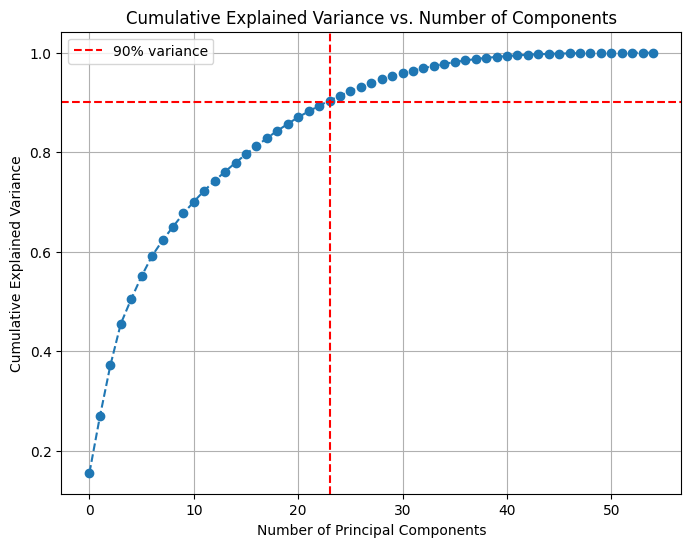

24


In [57]:
num = pca.Find_PCA_n(visualize=True)
print(num)

In [58]:
pca_df = pca.ApplyPCA(num)
pca_df.head(2)

,ID,_type,target,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
0,2023-01-01 00:00:00,train,2.0,-7.617367,3.888024,-0.307654,-1.385742,-0.170417,-1.184710,5.204310,...,-0.609106,-2.435980,0.662373,1.421656,0.073479,0.202664,0.844180,-0.257831,-0.461300,0.763459
1,2023-01-01 01:00:00,train,1.0,-5.115709,-1.794055,2.166241,-3.123035,-0.461568,-0.832601,1.330701,...,-1.024301,-1.772364,2.014642,2.341038,-0.137740,-0.251253,0.247316,-0.251895,-0.062814,-0.301387


In [59]:
intervals = [6,12,24,48,72]

# ccf 에서 상관성이 높았던 변수들 
col_lst = [f'PC{i+1}' for i in [1,3,5,11,12,13,18]]

df_select_ma = dataset_gen.moving_average(pca_df, col_lst, intervals)


In [60]:
shift_intervals = [_ for _ in range(1, 24)]

df_shifted = dataset_gen.shift_feature(df_select_ma, col_lst, shift_intervals)


In [61]:
df_shifted.head(2)

,ID,_type,target,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,PC19_14,PC19_15,PC19_16,PC19_17,PC19_18,PC19_19,PC19_20,PC19_21,PC19_22,PC19_23
0,2023-01-01 00:00:00,train,2.0,-7.617367,3.888024,-0.307654,-1.385742,-0.170417,-1.184710,5.204310,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-01 01:00:00,train,1.0,-5.115709,-1.794055,2.166241,-3.123035,-0.461568,-0.832601,1.330701,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
_target = df_shifted["target"]
final_df = df_shifted.ffill().fillna(-999).assign(target = _target)

train_df = final_df[final_df._type == 'train'].drop(columns = '_type')
test_df = final_df[final_df._type == 'test'].drop(columns = '_type')


In [69]:
# train_test_split 으로 valid set, train set 분리
x_train_random, x_valid_random, y_train_random, y_valid_random = train_test_split(
    train_df.drop(columns = ['ID', 'target']), 
    train_df["target"].astype(int), 
    test_size=0.2,
    random_state=42,
    stratify=train_df["target"].astype(int) 
)


In [70]:
# time series valid, train set 분리
x_train_ts = train_df[train_df.ID < '2023-11-01'].drop(["target", "ID"], axis = 1)
y_train_ts = train_df[train_df.ID < '2023-11-01']["target"].astype(int)

x_valid_ts = train_df[train_df.ID >= '2023-11-01'].drop(["target", "ID"], axis = 1)
y_valid_ts = train_df[train_df.ID >= '2023-11-01']["target"].astype(int)

In [71]:
x_train_random.replace([np.inf, -np.inf], np.nan, inplace=True)
x_valid_random.replace([np.inf, -np.inf], np.nan, inplace=True)

x_train_ts.replace([np.inf, -np.inf], np.nan, inplace=True)
x_valid_ts.replace([np.inf, -np.inf], np.nan, inplace=True)

In [72]:
lgbm_model = LGBM(lgbm_params)
xgb_model = XGB(lgbm_params)
catboost_model = CatBoost(catboost_params)

lgbm_model.train(x_train_random, y_train_random, x_valid_random, y_valid_random)
xgb_model.train(x_train_random, y_train_random, x_valid_random, y_valid_random)
catboost_model.train(x_train_random, y_train_random, x_valid_random, y_valid_random)


[0]	validation_0-mlogloss:1.38135


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [04:27:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "boosting_type", "metric", "num_leaves", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-mlogloss:1.37644
[2]	validation_0-mlogloss:1.37164
[3]	validation_0-mlogloss:1.36688
[4]	validation_0-mlogloss:1.36228
[5]	validation_0-mlogloss:1.35779
[6]	validation_0-mlogloss:1.35333
[7]	validation_0-mlogloss:1.34900
[8]	validation_0-mlogloss:1.34486
[9]	validation_0-mlogloss:1.34062
[10]	validation_0-mlogloss:1.33664
[11]	validation_0-mlogloss:1.33275
[12]	validation_0-mlogloss:1.32888
[13]	validation_0-mlogloss:1.32516
[14]	validation_0-mlogloss:1.32140
[15]	validation_0-mlogloss:1.31792
[16]	validation_0-mlogloss:1.31442
[17]	validation_0-mlogloss:1.31096
[18]	validation_0-mlogloss:1.30759
[19]	validation_0-mlogloss:1.30431
[20]	validation_0-mlogloss:1.30110
[21]	validation_0-mlogloss:1.29801
[22]	validation_0-mlogloss:1.29476
[23]	validation_0-mlogloss:1.29176
[24]	validation_0-mlogloss:1.28885
[25]	validation_0-mlogloss:1.28594
[26]	validation_0-mlogloss:1.28312
[27]	validation_0-mlogloss:1.28040
[28]	validation_0-mlogloss:1.27761
[29]	validation_0-mlogloss:1.

In [73]:
lgbm_importance = lgbm_model.model.feature_importances_
lgbm_importance_df = pd.DataFrame({
    'Feature': x_train_random.columns,
    'Importance': lgbm_importance
})
top_20_lgbm_features = lgbm_importance_df.sort_values(by='Importance', ascending=False).head(20)['Feature']


xgb_importance = xgb_model.model.feature_importances_
xgb_importance_df = pd.DataFrame({
    'Feature': x_train_random.columns,
    'Importance': xgb_importance
})
top_20_xgb_features = xgb_importance_df.sort_values(by='Importance', ascending=False).head(20)['Feature']


catboost_importance = catboost_model.model.get_feature_importance()
catboost_importance_df = pd.DataFrame({
    'Feature': x_train_random.columns,
    'Importance': catboost_importance
})
top_20_catboost_features = catboost_importance_df.sort_values(by='Importance', ascending=False).head(20)['Feature']


combined_top_features = pd.concat([top_20_lgbm_features, top_20_xgb_features, top_20_catboost_features]).unique()

list1 = list(set(combined_top_features))


In [74]:
lgbm_model = LGBM(lgbm_params)
xgb_model = XGB(lgbm_params)
catboost_model = CatBoost(catboost_params)

lgbm_model.train(x_train_ts, y_train_ts, x_valid_ts, y_valid_ts)
xgb_model.train(x_train_ts, y_train_ts, x_valid_ts, y_valid_ts)
catboost_model.train(x_train_ts, y_train_ts, x_valid_ts, y_valid_ts)


[0]	validation_0-mlogloss:1.38170


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [04:28:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "boosting_type", "metric", "num_leaves", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-mlogloss:1.37718
[2]	validation_0-mlogloss:1.37285
[3]	validation_0-mlogloss:1.36834
[4]	validation_0-mlogloss:1.36412
[5]	validation_0-mlogloss:1.35989
[6]	validation_0-mlogloss:1.35581
[7]	validation_0-mlogloss:1.35183
[8]	validation_0-mlogloss:1.34792
[9]	validation_0-mlogloss:1.34424
[10]	validation_0-mlogloss:1.34043
[11]	validation_0-mlogloss:1.33668
[12]	validation_0-mlogloss:1.33313
[13]	validation_0-mlogloss:1.32963
[14]	validation_0-mlogloss:1.32623
[15]	validation_0-mlogloss:1.32286
[16]	validation_0-mlogloss:1.31944
[17]	validation_0-mlogloss:1.31603
[18]	validation_0-mlogloss:1.31274
[19]	validation_0-mlogloss:1.30949
[20]	validation_0-mlogloss:1.30638
[21]	validation_0-mlogloss:1.30340
[22]	validation_0-mlogloss:1.30045
[23]	validation_0-mlogloss:1.29748
[24]	validation_0-mlogloss:1.29456
[25]	validation_0-mlogloss:1.29201
[26]	validation_0-mlogloss:1.28924
[27]	validation_0-mlogloss:1.28638
[28]	validation_0-mlogloss:1.28376
[29]	validation_0-mlogloss:1.

In [75]:
lgbm_importance = lgbm_model.model.feature_importances_
lgbm_importance_df = pd.DataFrame({
    'Feature': x_train_random.columns,
    'Importance': lgbm_importance
})
top_20_lgbm_features = lgbm_importance_df.sort_values(by='Importance', ascending=False).head(20)['Feature']


xgb_importance = xgb_model.model.feature_importances_
xgb_importance_df = pd.DataFrame({
    'Feature': x_train_random.columns,
    'Importance': xgb_importance
})
top_20_xgb_features = xgb_importance_df.sort_values(by='Importance', ascending=False).head(20)['Feature']


catboost_importance = catboost_model.model.get_feature_importance()
catboost_importance_df = pd.DataFrame({
    'Feature': x_train_random.columns,
    'Importance': catboost_importance
})
top_20_catboost_features = catboost_importance_df.sort_values(by='Importance', ascending=False).head(20)['Feature']


combined_top_features = pd.concat([top_20_lgbm_features, top_20_xgb_features, top_20_catboost_features]).unique()

list2 = list(set(combined_top_features))


In [76]:
df2_list = list1 + list2
print(len(df2_list))
df2_list


92


['PC13_21',
 'PC19_16',
 'PC13_3',
 'PC2_MA6',
 'PC4',
 'PC19_10',
 'PC10',
 'PC22',
 'PC2_MA48',
 'PC13_MA48',
 'PC3',
 'PC24',
 'PC2_10',
 'PC13_15',
 'PC2',
 'PC2_21',
 'PC6_5',
 'PC14_21',
 'PC6_9',
 'PC19_7',
 'PC12_1',
 'PC13_MA6',
 'PC8',
 'PC4_11',
 'PC13_22',
 'PC4_MA6',
 'PC6_20',
 'PC6_8',
 'PC4_2',
 'PC14_16',
 'PC23',
 'PC6_4',
 'PC12_18',
 'PC2_9',
 'PC6_17',
 'PC19_21',
 'PC2_5',
 'PC4_MA12',
 'PC2_6',
 'PC4_20',
 'PC9',
 'PC16',
 'PC6_MA24',
 'PC14_6',
 'PC13_21',
 'PC6_MA72',
 'PC19_16',
 'PC2_MA6',
 'PC4',
 'PC19_14',
 'PC10',
 'PC22',
 'PC2_MA48',
 'PC4_3',
 'PC13_MA72',
 'PC2_MA72',
 'PC14_10',
 'PC4_7',
 'PC19_13',
 'PC3',
 'PC2_10',
 'PC6_14',
 'PC2',
 'PC14_21',
 'PC4_MA48',
 'PC13_MA6',
 'PC6_12',
 'PC4_MA6',
 'PC2_16',
 'PC6_23',
 'PC2_13',
 'PC4_5',
 'PC19_23',
 'PC4_MA24',
 'PC13_1',
 'PC6_8',
 'PC12_8',
 'PC4_2',
 'PC13_11',
 'PC23',
 'PC2_MA12',
 'PC2_MA24',
 'PC14_23',
 'PC19_21',
 'PC4_23',
 'PC6_6',
 'PC4_MA12',
 'PC4_1',
 'PC2_18',
 'PC9',
 'PC19_15',
 

In [77]:
df2 = df_shifted[df2_list]
df2.head()


,PC13_21,PC19_16,PC13_3,PC2_MA6,PC4,PC19_10,PC10,PC22,PC2_MA48,PC13_MA48,...,PC14_23,PC19_21,PC4_23,PC6_6,PC4_MA12,PC4_1,PC2_18,PC9,PC19_15,PC13_18
0,NaN,NaN,NaN,NaN,-1.385742,NaN,-1.425413,-0.257831,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.362591,NaN,NaN
1,NaN,NaN,NaN,NaN,-3.123035,NaN,0.560041,-0.251895,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.385742,NaN,3.719657,NaN,NaN
2,NaN,NaN,NaN,NaN,-3.382284,NaN,-0.726368,-0.465489,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-3.123035,NaN,0.960098,NaN,NaN
3,NaN,NaN,1.736109,NaN,-2.975941,NaN,-1.688376,-0.046732,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-3.382284,NaN,1.011413,NaN,NaN
4,NaN,NaN,1.449590,NaN,-2.437329,NaN,-2.479295,0.109542,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-2.975941,NaN,0.774695,NaN,NaN


# DF3 - 상승 하락 확률

In [79]:
up_down_df = df_select_ma_shift.copy()

In [80]:
# 타겟 변수 생성 (예: 4개 클래스로 분류)
up_down_df['target_direction'] = np.where(up_down_df['target'] >= 2, 1, 0)

In [83]:
train_df = up_down_df[up_down_df._type == 'train'].drop(columns='_type')
test_df = up_down_df[up_down_df._type == 'test'].drop(columns='_type')


In [84]:
# train_test_split 으로 valid set, train set 분리
x_train_random, x_valid_random, y_train_dir_random, y_valid_dir_random = train_test_split(
    train_df.drop(columns=['target_direction', 'ID', 'target']),
    train_df["target_direction"].astype(int),
    test_size=0.2,
    random_state=42,
    stratify=train_df['target']
)

In [85]:
# time series valid, train set 분리
x_train_ts = train_df[train_df.ID < '2023-11-01'].drop(columns=['target_direction', 'ID', 'target'])
y_train_dir_ts = train_df[train_df.ID < '2023-11-01']["target_direction"]

x_valid_ts = train_df[train_df.ID >= '2023-11-01'].drop(columns=['target_direction', 'ID', 'target'])
y_valid_dir_ts = train_df[train_df.ID >= '2023-11-01']["target_direction"]

In [86]:
def catboost_train(x_train, y_train, x_valid, y_valid, params):
    model = CatBoost(params)  # CatBoost 클래스 인스턴스 생성
    model.train(x_train, y_train, x_valid, y_valid)  # 모델 학습
    return model

In [88]:
params = {
    'iterations': 200,
    'learning_rate': 0.02,
    'depth': 6,
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'random_seed': 42,
    'verbose': 0
}

In [89]:
# 모델 학습
catboost_random = catboost_train(x_train_random, y_train_dir_random, x_valid_random, y_valid_dir_random, params)
catboost_ts = catboost_train(x_train_ts, y_train_dir_ts, x_valid_ts, y_valid_dir_ts, params)


In [90]:
# random split 버전
dir_prob_train_random = catboost_random.predict_proba(x_train_random)[:, 1]
dir_prob_valid_random = catboost_random.predict_proba(x_valid_random)[:, 1]
dir_prob_random = np.concatenate((dir_prob_train_random, dir_prob_valid_random))


In [91]:
# ts split 버전
dir_prob_train_ts = catboost_ts.predict_proba(x_train_ts)[:, 1]
dir_prob_valid_ts = catboost_ts.predict_proba(x_valid_ts)[:, 1]
dir_prob_ts = np.concatenate((dir_prob_train_ts, dir_prob_valid_ts))


In [92]:
# 테스트셋용 
x_test_full = test_df.drop(columns=['ID', 'target', 'target_direction'])
dir_prob_random_test = catboost_random.predict_proba(x_test_full)[:, 1]  # random 용
dir_prob_ts_test = catboost_ts.predict_proba(x_test_full)[:, 1]  # ts 용


In [93]:
# 결과 데이터프레임 생성
df3_1 = pd.DataFrame({
    'dir_prob_ts': dir_prob_ts,
    'dir_prob_random': dir_prob_random
})

df3_2 = pd.DataFrame({
    'dir_prob_ts': dir_prob_ts_test,
    'dir_prob_random': dir_prob_random_test
})

df3 = pd.concat([df3_1, df3_2], axis=0).reset_index(drop=True)
df3

,dir_prob_ts,dir_prob_random
0,0.552022,0.490436
1,0.493622,0.478015
2,0.505858,0.468680
3,0.517057,0.515577
4,0.535935,0.454363
...,...,...
11547,0.524118,0.522381
11548,0.549094,0.518622
11549,0.519450,0.520828
11550,0.533251,0.517925


# Concat DF

In [94]:
df4 = pd.concat([df[['ID','_type','target']],df1, df2, df3],axis=1)
df4

,ID,_type,target,short_liquidations_MA6,open_interest_11,short_liquidations,tokens_transferred_mean_16,liquidation_diff_bybit_MA24,taker_interest_ratio,tokens_transferred_median_MA48,...,PC4_23,PC6_6,PC4_MA12,PC4_1,PC2_18,PC9,PC19_15,PC13_18,dir_prob_ts,dir_prob_random
0,2023-01-01 00:00:00,train,2.0,NaN,NaN,0.000000,NaN,NaN,0.009775,NaN,...,NaN,NaN,NaN,NaN,NaN,0.362591,NaN,NaN,0.552022,0.490436
1,2023-01-01 01:00:00,train,1.0,NaN,NaN,0.065954,NaN,NaN,0.005718,NaN,...,NaN,NaN,NaN,-1.385742,NaN,3.719657,NaN,NaN,0.493622,0.478015
2,2023-01-01 02:00:00,train,1.0,NaN,NaN,0.000000,NaN,NaN,0.003795,NaN,...,NaN,NaN,NaN,-3.123035,NaN,0.960098,NaN,NaN,0.505858,0.468680
3,2023-01-01 03:00:00,train,1.0,NaN,NaN,0.000000,NaN,NaN,0.005433,NaN,...,NaN,NaN,NaN,-3.382284,NaN,1.011413,NaN,NaN,0.517057,0.515577
4,2023-01-01 04:00:00,train,2.0,NaN,NaN,0.000000,NaN,NaN,0.005602,NaN,...,NaN,NaN,NaN,-2.975941,NaN,0.774695,NaN,NaN,0.535935,0.454363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,2024-04-26 03:00:00,test,NaN,0.080011,1.364595,0.026733,0.171684,0.510779,0.043069,0.002637,...,-0.465640,1.016935,0.371891,-1.481492,0.061787,-1.449475,1.080843,-0.466491,0.524118,0.522381
11548,2024-04-26 04:00:00,test,NaN,0.082472,1.354928,0.016717,0.220157,0.510924,0.045065,0.002596,...,-0.036917,1.175799,0.664057,-1.753339,3.318017,-0.787887,1.606129,0.596448,0.549094,0.518622
11549,2024-04-26 05:00:00,test,NaN,0.118890,1.362782,0.224140,0.335834,0.510654,0.045615,0.002568,...,-1.057082,-0.624102,0.725512,2.951054,2.003582,0.511657,0.110116,-0.994771,0.519450,0.520828
11550,2024-04-26 06:00:00,test,NaN,0.133576,1.362370,0.119825,0.592178,0.510269,0.045773,0.002525,...,0.175508,1.819538,0.634214,2.728662,-0.109681,-0.481870,-0.355295,0.051738,0.533251,0.517925
